# Hypergraph information

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from tqdm import tqdm
from itertools import combinations

sys.path.append("../src/")

import xgi
from reducibility_hg import *

sb.set_theme(style="ticks", context="paper")

In [2]:
results_dir = "../results/"
out_dir  = f"{results_dir}synthetic/"

In [3]:
def plot_3panels(info_losses, complexities, orders, labels, legend_title=None):
    
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 2.1), constrained_layout=True, sharey=True)

    n = len(info_losses)
    
    for i in range(n):
        ax1.plot(orders[i], info_losses[i], "o-", label=labels[i], ms=7, mfc="w", lw=2)      

    ax1.set_title("Information Loss (KL)")
    ax1.set_xlabel("Max Order")
    ax1.set_ylabel("Bits")
    
    for i in range(n):
        ax2.plot(orders[i], complexities[i], "o-", label=labels[i], ms=7, mfc="w", lw=2)      

    ax2.set_title("Model Complexity ($\delta S$)")
    ax2.set_xlabel("Max Order")
    
    for i in range(n):
        message_length = complexities[i] + info_losses[i]
        ax3.plot(orders[i], message_length, "o-", label=labels[i], ms=7, mfc="w", lw=2)

    ax3.legend(title=legend_title, bbox_to_anchor=(1, 0.5), frameon=False, loc="center left")

    ax3.set_title("Message Length")
    ax3.set_xlabel("Max Order")

    sb.despine()

    #fig.suptitle(f"Complete hypergraph N={N}")

    #fig_name = f"message_length_complete_hypergraph_N{N}" #lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"

    #plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")
    
    return fig, (ax1, ax2, ax3)

# Random Simplicial Complex up to order 4

In [4]:
N = 100
ps = 5 * np.array([1/N, 1/N**2, 1/N**3, 1/N**4])

H0 = xgi.random_simplicial_complex(N, ps=ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

In [5]:
tau_c = find_charact_tau(H0, orders, weights, rescale_per_node=False)
tau_c

0.01837792426533645

In [6]:
Ds_H = np.zeros((100,4,4))
lZs_H = np.zeros((100,4,4))

for rep in range(100): 
    if (rep+1)%100==0:
        print(rep+1)
    for i, p in enumerate(np.linspace(0,0.9,4)):
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Ds_H[rep,i], lZs_H[rep,i], _ = compute_information(H, tau_c, rescale_per_node=False)

100


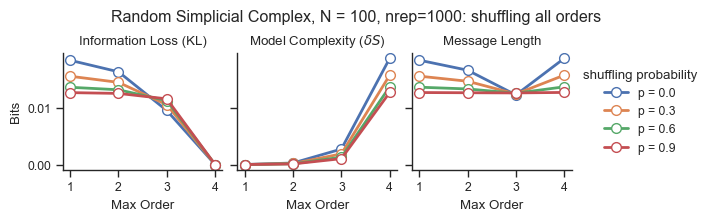

In [36]:
plot_3panels(np.mean(Ds_H, axis=0), np.mean(lZs_H, axis=0), [orders, orders, orders, orders], 
             ["p = 0.0", "p = 0.3", "p = 0.6", "p = 0.9"], legend_title="shuffling probability")
plt.suptitle("Random Simplicial Complex, N = 100, nrep=1000: shuffling all orders")

fig_name = f"message_length_random_simplicial_complex_N_100_p_0_03_06_09"

#plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [12]:
Ds_H = np.zeros((100,4,4))
lZs_H = np.zeros((100,4,4))

for rep in range(100): 
    if (rep+1)%100==0:
        print(rep+1)
    for i, p in enumerate(np.linspace(0.25,1,4)):
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Ds_H[rep,i], lZs_H[rep,i], _ = compute_information(H, tau_c, rescale_per_node=False)

100


In [24]:
message_lengths = dict()

def pad_arr_list(arr_list):
    max_shape = max([a.shape[0] for a in arr_list])

    # Pad the shorter arrays with zeros
    padded_arr_list = [np.pad(a, (0, max_shape-a.shape[0]), mode='constant', constant_values=None) for a in arr_list]
    return padded_arr_list

for i, p in enumerate(np.linspace(0.25,1,4)):
    message_lengths[p] = pad_arr_list(Ds_H[:,i,:] + lZs_H[:,i,:])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()
df

0
0.25 0   [0.01709237045141343, 0.014594244590120764, 0....
     1   [0.013890573566872195, 0.012530159952431476, 0...
     2   [0.014752382792436868, 0.012676202070582163, 0...
     3   [0.016875125379403257, 0.014827957379808035, 0...
     4   [0.015746993690676097, 0.013951665071330926, 0...
...                                                    ...
1.00 95  [0.00993103353393521, 0.009780304277305966, 0....
     96  [0.010016766723090965, 0.010177610305495487, 0...
     97  [0.010681516272985792, 0.01059116030704986, 0....
     98  [0.00938848077242245, 0.009330465860151939, 0....
     99  [0.010279447229921707, 0.010227066633951922, 0...

[400 rows x 1 columns]

In [25]:
for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])
    
df = df[orders]
df

1         2         3         4
0.25 0   0.017092  0.014594  0.010533  0.017655
     1   0.013891  0.012530  0.011214  0.014284
     2   0.014752  0.012676  0.011400  0.015137
     3   0.016875  0.014828  0.011042  0.017348
     4   0.015747  0.013952  0.011836  0.016138
...           ...       ...       ...       ...
1.00 95  0.009931  0.009780  0.009484  0.009909
     96  0.010017  0.010178  0.009513  0.009941
     97  0.010682  0.010591  0.010604  0.010650
     98  0.009388  0.009330  0.008831  0.009398
     99  0.010279  0.010227  0.010595  0.010371

[400 rows x 4 columns]

In [26]:
dff = df.reset_index(names=["rewiring probability", "iteration"]).melt(
    id_vars=["rewiring probability", "iteration"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:1.295e-09 t=-6.418e+00
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:4.487e-01 t=-7.591e-01
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:7.281e-01 t=3.482e-01
0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:4.020e-40 t=-1.863e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:5.377e-02 t=1.940e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:3.822e-66 t=-3.493e+01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:3.800e-24 t=1.172e+01
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:7.207e-50 t=2.315e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:1.196e-10 t=6.820e+00
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:2.399e-22 t=1.130

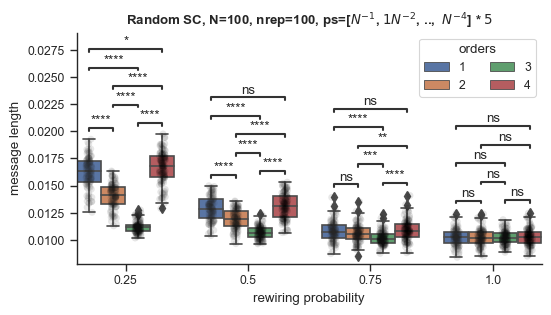

In [27]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(6, 3))

#palette = sb.color_palette("Set1", n_colors=4)

#box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
    #'whiskerprops':{'color':'blue'},
    #'capprops':{'color':'yellow'}
#}

sb.boxplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax)#, **box_params)
plt.legend(title= "orders",ncols = 2)

sb.stripplot(data=dff, hue="order", y="message length", x="rewiring probability", ax=ax, color="black", dodge=True, alpha=0.1, legend=False)

sb.despine()
ax.set_title(rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $1 N^{{-2}}$, ..,  $N^{{-4}}$] * $5$", weight="bold")


pairs = []
for p in np.linspace(0.25,1,4):
    pairs.append( [(p, 3), (p, 4) ] )
    pairs.append( [(p, 1), (p, 2) ] )
    pairs.append( [(p, 1), (p, 3) ] )
    pairs.append( [(p, 1), (p, 4) ] )
    pairs.append( [(p, 2), (p, 3) ] )
    pairs.append( [(p, 2), (p, 4) ] )

annotator = Annotator(ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order")
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()

#fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_5_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")